In [1]:
# libraries
using Metrics          # r2-score
using Random
using Distributions
using Plots; gr()
using Printf

using CSV
using DataFrames
using MLJ              # blobs

In [2]:
function cross_entropy_loss(w, X, y)
    xpn = -y .* (X * w)
    res = log.(1 .+ exp.(xpn))    
    loss = mean(res)
end

# teste da função
X_teste = [1 2 4;
           3 2 6;
           7 9 3
           12 1 7]
N = size(X_teste)[1]
d = size(X_teste)[2]

y_teste = [0.2;
           0.7;
           0.9
           1.4]

rng = Random.seed!(1)            # generate seed
w_teste = randn(rng, d)          # generate initial w vector
display(w_teste)

cross_entropy_loss(w_teste, X_teste, y_teste)


3-element Array{Float64,1}:
  0.2972879845354616
  0.3823959677906078
 -0.5976344767282311

0.8299617724333166

In [3]:
# computes the gradient (ascent)
# gradient descent = - gradient ascent
function cross_entropy_gradient(w, X, y)
    xpn = -y .* (X * w)

    numerator = (y .* X)
    denominator = 1 .+ exp.(xpn)
    res = numerator ./ denominator
    grad = mean(res, dims=1)'   # média por coluna
end

# teste da função
cross_entropy_gradient(w_teste, X_teste, y_teste)

3×1 LinearAlgebra.Adjoint{Float64,Array{Float64,2}}:
 3.4113566130690804
 2.218871286496915
 1.9816190628587482

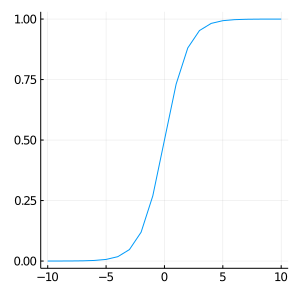

In [4]:
sigmoid(z) = 1 ./ (1 .+ exp.(-z))

# teste da função
a = -10:10
b = sigmoid(a)
gr()
plot(a, b, legend=false, size=(300,300))

In [5]:
function predict_logistic(w, X)
    N  = size(X)[1]
    Xe = hcat(ones(N), X)
    p  = sigmoid(Xe * w)
end

# teste da função
rng = Random.seed!(1)
w_teste = randn(rng, d+1)
predict_logistic(w_teste, X_teste)

4-element Array{Float64,1}:
 0.36415713997313365
 0.5464991148634797
 0.08046940511407982
 0.9854468597627305

In [6]:
function train_logistic(X, y, learning_rate = 0.1, num_iterations = 5000, return_history = false)

    N = size(X)[1]
    d = size(X)[2]
    Xe = hcat(ones(N), X)      # add ones to first column

    rng = Random.seed!(1)      # generate seed
    w0 = randn(rng, d+1)       # generate random initial w vector
    
    wt = copy(w0)
    w_history = Vector{Matrix{Float64}}()
    cross_entropy_loss_history = []         # = Vector{Float64}()
    
    for t in 1:num_iterations
        if return_history
            push!(w_history, wt')
            push!(cross_entropy_loss_history, cross_entropy_loss(wt, Xe, y))
        end
        
        gt = cross_entropy_gradient(wt, Xe, y)   # get the gradient
        vt = -gt                                 # get the gradient descent
        wt = wt + learning_rate .* vt            # compute the weight
    end
    
    w = w_history[argmin(cross_entropy_loss_history)]'
    
    if return_history
        return (w, w_history, cross_entropy_loss_history)
    else
        return w
    end
end

# teste da função
w_logistic, w_history, cross_entropy_loss_history = train_logistic(X_teste, y_teste, 1e-5, 10, true)
display(w_logistic)
display(w_history)
display(cross_entropy_loss_history)

4×1 LinearAlgebra.Adjoint{Float64,Array{Float64,2}}:
  0.2972879845354616
  0.3823959677906078
 -0.5976344767282311
 -0.01044524463737564

10-element Array{Array{Float64,2},1}:
 [0.2972879845354616 0.3823959677906078 -0.5976344767282311 -0.01044524463737564]
 [0.29728309997685043 0.3823494682861642 -0.5976423372635776 -0.01047689233590281]
 [0.29727821563110707 0.38230296986875173 -0.5976501967485573 -0.010508539028537791]
 [0.29727333149820484 0.3822564725382487 -0.5976580551834878 -0.010540184715320991]
 [0.297268447578117 0.38220997629453357 -0.5976659125686862 -0.010571829396292719]
 [0.29726356387081687 0.38216348113748505 -0.5976737689044698 -0.010603473071493176]
 [0.2972586803762778 0.3821169870669821 -0.5976816241911556 -0.010635115740962462]
 [0.2972537970944731 0.38207049408290383 -0.5976894784290605 -0.01066675740474057]
 [0.2972489140253761 0.38202400218512966 -0.5976973316185015 -0.010698398062867388]
 [0.2972440311689603 0.38197751137353914 -0.5977051837597952 -0.010730037715382699]

10-element Array{Any,1}:
 0.9203476266953606
 0.9204825327063354
 0.920617442610683
 0.9207523564076902
 0.9208872740966461
 0.9210221956768398
 0.9211571211475622
 0.9212920505081047
 0.9214269837577597
 0.9215619208958212

### Create blobs

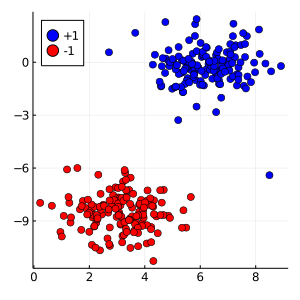

In [7]:
N = 300
X, y = make_blobs(N, 2; centers=2, cluster_std = 1, rng=7)
X = DataFrame(X) |> Array
y[ y .== 2 ] .= -1
y = y |> Array
y = y * 1.0

scatter(X[y .== 1, 1], X[y .== 1, 2], markercolor = "blue", label = "+1", legend = :topleft, size=(300,300))
scatter!(X[y .== -1, 1], X[y .== -1, 2],  markercolor = "red",  label = "-1")

Iteração p/ erro mínimo: 24
Erro mínimo: 2.834976338950468
Weight para erro mínimo: [0.2176495716254103; -0.1163462526170723; -0.5722121807994771]


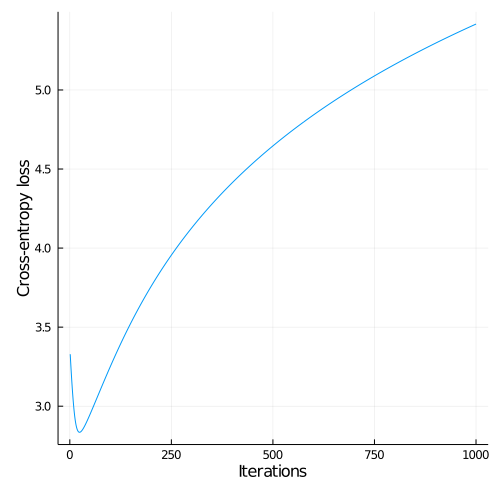

In [8]:
npoints = 1000
wl, w_history, loss_history = train_logistic(X, y, 0.01, npoints, true)
ind = argmin(loss_history)

println("Iteração p/ erro mínimo: ", ind)
println("Erro mínimo: ", loss_history[ind])
println("Weight para erro mínimo: ", wl)

plot(1:npoints, loss_history, legend=false, xlabel = "Iterations", ylabel = "Cross-entropy loss", size=(500,500))

In [9]:
p = predict_logistic(wl, X)

300×1 Array{Float64,2}:
 0.9851766780945674
 0.6154445813531165
 0.46527626013661544
 0.42901654749495494
 0.9947556368815258
 0.9864338669518302
 0.9853306108856005
 0.28548260563794936
 0.9890179643452802
 0.40253984441474927
 0.47817740760072647
 0.9784250398614933
 0.989529290879176
 ⋮
 0.3987456454733003
 0.3727685199729103
 0.9957550217126703
 0.9857391387967022
 0.3573621338606075
 0.9974597983839641
 0.48711713590913247
 0.24076869421731564
 0.2693808995675158
 0.43153233059626667
 0.36770573198350026
 0.367160430607236